In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import clean_axis

%matplotlib inline

# Codificació i modulació d'una seqüència aleatoria

## Generació de la seqüència

Es defineix una funció `gen_random(size)` que generará una seqüència de `size` lletres pseudo-aleatória. Cal tenir en compte que si la longitud no és compatible amb la mida del encriptador (e.g. 3) es farà padding. 

In [2]:
import random
def gen_random(size, froms = 'abcdefghijklmnopqrstuvwxyz'):
    return ''.join(random.choices(froms, k = size))

SIZE = 27
print('Seqüència random de {} lletres: {}'.format(SIZE, gen_random(SIZE)))

Seqüència random de 27 lletres: sfqzzyxvuacwtebirkixamyuaaa


## Conversió

A `converters` es defineixen dues classes: `BinaryConverter` i `StringConverter` que permetran convertir respectivament int a binari i string a int (i viceversa). Els caraters que no es poden codificar s'ometen.

In [3]:
from converters import StringConverter
sc = StringConverter(None)

seq = 'abc?def'
decoded_seq = sc.str2int(seq)
encoded_seq = sc.int2str(decoded_seq)
bin_seq = sc.int2str(decoded_seq)
from_bin_seq = sc.str2int(bin_seq)
print('String/Int: {} -> {} -> {}'.format(seq, decoded_seq, encoded_seq))
print('Binari/Int: {} -> {} -> {}'.format(decoded_seq, ''.join(map(str,bin_seq)), from_bin_seq))

String/Int: abc?def -> [0 1 2 3 4 5] -> abcdef
Binari/Int: [0 1 2 3 4 5] -> abcdef -> [0 1 2 3 4 5]


## Encriptació

Per encriptar les seqüències de enters es defineix una classe `Encryptor` que s'encarrega de dur a terme les tasques de encriptació i decriptació donada una clau (en forma de matriu i la seva inversa).

In [4]:
from encryption import Encryptor

seq = np.array([1,2,3,4,5,6])
enc = Encryptor()

enc_seq = enc.encrypt(seq)
dec_seq = enc.decrypt(enc_seq)
print('{} -encriptar-> {} -decriptar-> {}'.format(seq, enc_seq, dec_seq))

[1 2 3 4 5 6] -encriptar-> [ 5 23 21 20 10 21] -decriptar-> [1 2 3 4 5 6]


# Senyals codificades

En el modul `encoders` s'han implementat les 8 codificacions per a senyals binàries vistes a classe. A continuació un exemple comparatiu per a una sequéncia d'exemple donada `00110010`.

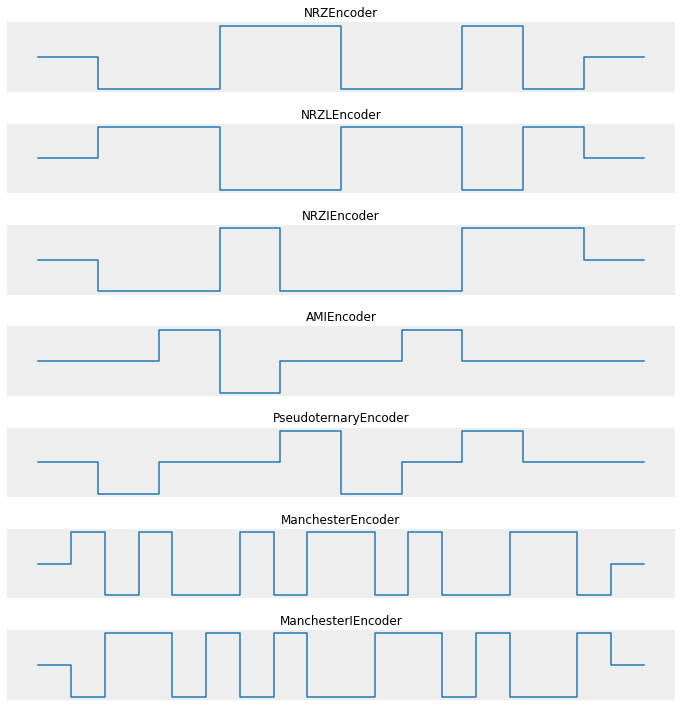

In [5]:
from encoders import *

codificacions = [
    ('NRZEncoder', NRZEncoder()), 
    ('NRZLEncoder', NRZLEncoder()), 
    ('NRZIEncoder',NRZIEncoder()), 
    ('AMIEncoder',AMIEncoder()), 
    ('PseudoternaryEncoder', PseudoternaryEncoder()),
    ('ManchesterEncoder', ManchesterEncoder()), 
    ('ManchesterIEncoder',DifManchesterEncoder()),
]

def show_encoding(name, seq_cod):
    fig, ax = plt.subplots()
    ax.set_title(name)
    ax.set_facecolor('#EEEEEE')
    clean_axis(ax)
    ys = np.pad(seq_cod, (2,1))
    xs = np.arange(len(ys))
    plt.step(xs, ys)

def show_encodings_sequence(bs):
    fig, axes = plt.subplots(len(codificacions), figsize=(10, 10))
    fig.tight_layout()

    bs = [0,0,1,1,0,0,1,0]

    for (name, codif), ax in zip(codificacions, axes):
        ax.set_title(name)
        ax.set_facecolor('#EEEEEE')
        clean_axis(ax)
        ys = np.pad(codif.encode(bs), (2,1))
        xs = np.arange(len(ys))
        ax.step(xs, ys)
        
show_encodings_sequence([0,0,1,1,0,1,0])

# Modulació de senyals

Donada una senyal codificada en binari es defineix la class `Modulator` i els seus descendents, que donat

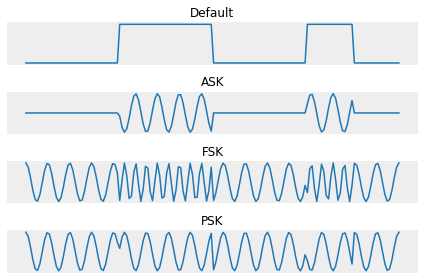

In [6]:
from modulators import *

FREQS = [1e4, 2e4, 3e4]
AMPS  = [0, 1, 0.5]
OFFS  = [0, np.pi, np.pi/2]
SAMPLES = 20

def show_modulation(name, xs, signal):
    fig, ax = plt.subplots()
    ax.set_title(name)
    ax.set_facecolor('#EEEEEE')
    clean_axis(ax)
    ax.plot(xs, signal)

def show_modulations(signal):
    uniq = np.unique(signal)
    defa = {v:v for v in uniq}
    frqs = {k:v for k,v in zip(uniq, FREQS)}
    amps = {k:v for k,v in zip(uniq, AMPS)}
    offs = {k:v for k,v in zip(uniq, OFFS)}
    modulators = [
        ('Default', DefaultModulator(defa)), 
        ('ASK', ASKModulator(amps)), 
        ('FSK', FSKModulator(frqs)), 
        ('PSK', PSKModulator(offs))
    ]
    fig, axes = plt.subplots(len(modulators))
    fig.set_tight_layout(True)

    for (name, modulator), ax in zip(modulators, axes):
        ax.set_title(name)
        ax.set_facecolor('#EEEEEE')
        clean_axis(ax)
        ys, xs = modulator.modulate(signal)
        ax.plot(xs,ys)

bs = [0,0,1,1,0,0,1,0]
show_modulations(bs)

## Tot junt...

In [7]:
def get_encoder(encoder):
    return {
        'NRZ': NRZEncoder(), 
        'NRZ': NRZLEncoder(), 
        'NRZ': NRZIEncoder(), 
        'AMI': AMIEncoder(), 
        'Pseudoternary': PseudoternaryEncoder(),
        'Manchester': ManchesterEncoder(), 
        'ManchesterI': DifManchesterEncoder(),
    }[encoder]

def get_modulator(modulator, codif): 
    lvls  = codif.levels()
    return {
        'ASK': ASKModulator({
           k:v for k,v in zip(lvls, np.linspace(0,1,len(lvls)))
        }),
        'FSK': FSKModulator({
            k:(1e3 * (i+1)) for i,k in enumerate(lvls)
        }),
        'PSK': PSKModulator({
            k:((np.pi * i) / len(lvls)) for i,k in enumerate(lvls)
        }),
    }[modulator]

In [8]:
# NOTA: per a una mida no divisible entre 3 s'afegirà padding al final
SIZE = 3
SAMPLES = 20

encrp = Encryptor()
sconv = StringConverter(encrp)

# Escollir modulador i encoder
codif = get_encoder('NRZ')
modul = get_modulator('FSK', codif)

In [9]:
# 1 generació de la seqüència
seq = gen_random(SIZE)
print('Seqüència inicial: {}'.format(seq))

Seqüència inicial: qdl


In [10]:
# 2 encriptació
seq_enc = sconv.from_string(seq)
print('Seqüència encriptada: \n{}'.format(seq_enc))

Seqüència encriptada: 
[0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1]


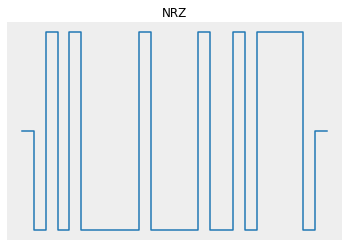

In [11]:
# 3 codificació
seq_cod = codif.encode(seq_enc)

# Mostrem els primers 10
show_encoding('NRZ', seq_cod)

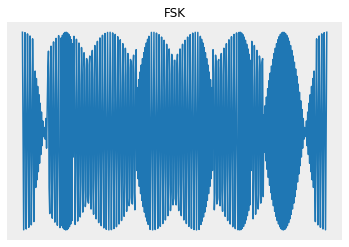

In [12]:
# 4 modulació
seq_mod, xs = modul.modulate(seq_cod, SAMPLES)

# Nota: si la mida es relativament gran, pot ser difícil de visualitzar!
show_modulation('FSK', xs, seq_mod)

In [13]:
# 5 Decodificar
seq_demod = modul.demodulate(seq_mod, xs)
seq_decod = codif.decode(seq_demod)

In [14]:
# 6 Desencriptar
seq_deenc = sconv.to_string(seq_decod)
print("Inicial:\t{}\nRecuperat:\t{}".format(seq,seq_deenc))

Inicial:	qdl
Recuperat:	qdl
